In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

from minimize import kalman_filter_smoother, post_pred

In [2]:
def sample_trajectory(m0, S0, A, Q, C, R, num_points):
    
    x = np.random.multivariate_normal(mean=m0, cov=S0)
    y = np.random.multivariate_normal(mean=np.dot(C, x), cov=R)
    
    x_ = np.array([x])
    y_ = np.array([y])
    
    for i in range(num_points - 1):
        
        x = np.random.multivariate_normal(mean=np.dot(A, x), cov=Q)
        y = np.random.multivariate_normal(mean=np.dot(C, x), cov=R)
        
        x_ = np.concatenate([x_[:], x[None, :]], axis=0)
        y_ = np.concatenate([y_[:], y[None, :]], axis=0)
    
    return x_, y_

In [3]:
def line_post_pred(dt, ms, Vs, CV):

    t = []
    mean = []
    var = []

    for i in range(num_points-1):

        for a in np.linspace(5e-3, 1 - 5e-3, 1000):

            dt1 = a * dt
            dt2 = (1 - a) * dt

            mean_, var_ = post_pred(dt1=dt1, m1=ms[i], V1=Vs[i], dt2=dt2, m2=ms[i+1], V2=Vs[i+1], CV=CV[i])
            
            t.append(i * dt + dt1)
            mean.append(mean_)
            var.append(np.diag(var_))
            
    mean = np.array(mean)
    var = np.array(var)
            
    return t, mean, var

In [4]:
# Dimensions of the latent and observed spaces
x_dim = 3
y_dim = 2

# Initial distribution matrices
m0 = np.array([0, -5, 0])
S0 = 1e-2 * np.eye(x_dim)

# Set the random seed for comparable figures
np.random.seed(0)

# Define matrices A, Q (dynamics)
num_points = 5
t = np.linspace(0, 5, num_points)
dt = t[1] - t[0]

# Overal variance parameter θ and log noise to signal ratio
theta2 = 10.
log_nsr = -2.

# Time dependent state space model matrices, used to generate data
A = lambda t : np.array([[1, t, t ** 2 / 2],
                         [0, 1, t],
                         [0, 0, 1]])
A = A(dt)

Q = lambda t : theta2 * np.array([[t ** 5 / 20, t ** 4 / 8, t ** 3 / 6],
                                  [t ** 4 / 8, t ** 3 / 3, t ** 2 / 2],
                                  [t ** 3 / 6, t ** 2 / 2, t]])
Q = Q(dt)

# Define matrices C, R (data emission)
C = np.eye(3)[:2, :]
R = np.array([[np.exp(log_nsr) * theta2, 0],
              [0,                        0]])

# Sample points
xs, ys = sample_trajectory(m0=m0, S0=S0, A=A, Q=Q, C=C, R=R, num_points=num_points)

mf, Vf, ms, Vs, CV, theta2, nlml = kalman_filter_smoother(t=t, y=ys, log_nsr=log_nsr)

/Users/stratis/repos/random-walks/venv-random-walks/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt
/Users/stratis/repos/random-walks/venv-random-walks/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


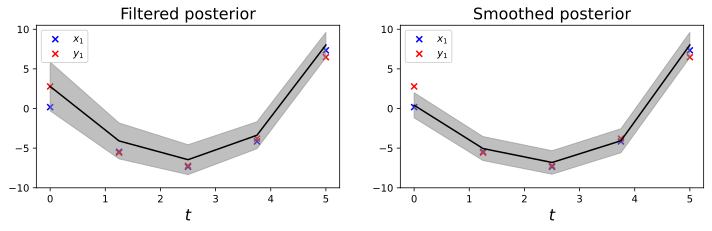

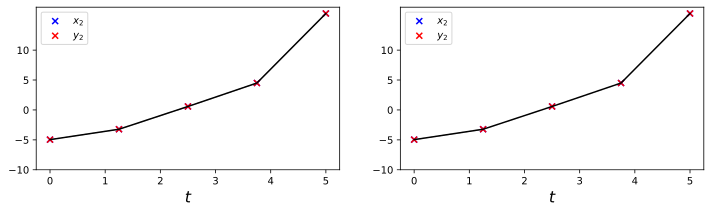

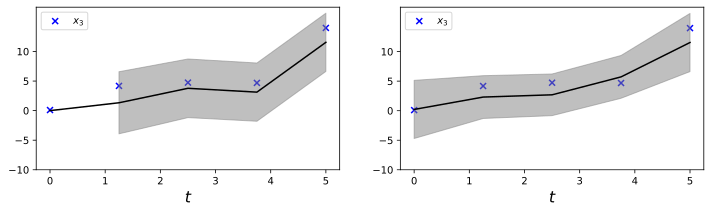

In [5]:
for i in range(3):
    
    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    
    plt.plot(t, mf[:, i], color='k')
    plt.scatter(t, xs[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, ys[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Filtered posterior', fontsize=16)
        
    plt.fill_between(t,
                     mf[:, i] - 2 * Vf[:, i, i] ** 0.5,
                     mf[:, i] + 2 * Vf[:, i, i] ** 0.5,
                     color='gray', alpha=0.5)
    
    plt.yticks(np.linspace(-10, 10, 5))
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()

    plt.subplot(122)
    plt.plot(t, ms[:, i], color='k')
    plt.scatter(t, xs[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, ys[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior', fontsize=16)
        
    plt.fill_between(t,
                     ms[:, i] - 2 * Vs[:, i, i] ** 0.5,
                     ms[:, i] + 2 * Vs[:, i, i] ** 0.5,
                     color='gray', alpha=0.5)
    
    plt.yticks(np.linspace(-10, 10, 5))
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()
    
plt.show()

/Users/stratis/repos/random-walks/venv-random-walks/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


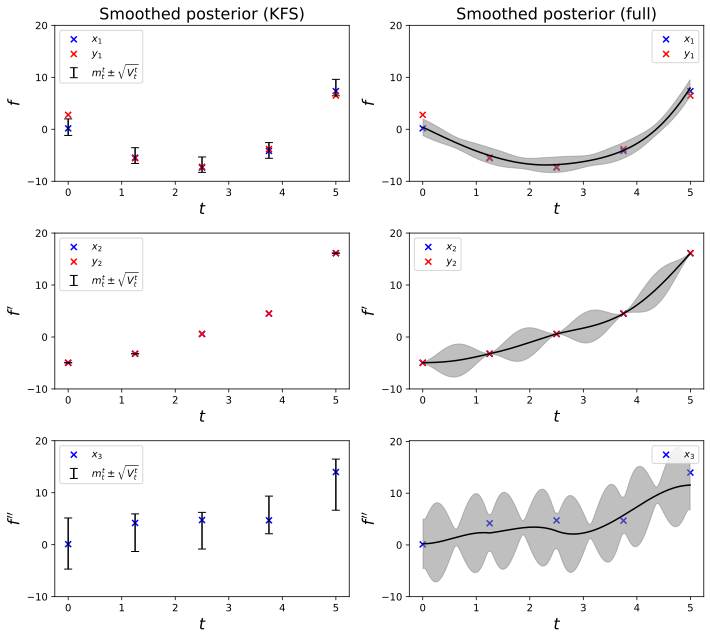

In [6]:
plt.figure(figsize=(10, 9))

for i in range(3):
    
    plt.subplot(3, 2, 2 * i + 1)
    
    plt.scatter(t, xs[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, ys[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (KFS)', fontsize=16)
    
    plt.errorbar(x=t,
                 y=ms[:, i],
                 yerr=2 * Vs[:, i, i] ** 0.5,
                 color='black',
                 zorder=2,
                 fmt="none",
                 label=r"$m_t^t \pm \sqrt{V_t^t}$",
                 capsize=4)
    
    plt.yticks(np.linspace(-10, 20, 4))
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()
    
    if i == 0:
        plt.ylabel(r'$f$', fontsize=16)
    if i == 1:
        plt.ylabel(r"$f'$", fontsize=16)
    if i == 2:
        plt.ylabel(r"$f''$", fontsize=16)

    plt.subplot(3, 2, 2 * i + 2)
    
    t_, m_, v_ = line_post_pred(dt, ms, Vs, CV)
    plt.plot(t_, m_[:, i], color='k')
    # plt.plot(ms[:, i], color='k')
    plt.scatter(t, xs[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, ys[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (full)', fontsize=16)

    plt.fill_between(t_,
                     m_[:, i] - 2 * v_[:, i] ** 0.5,
                     m_[:, i] + 2 * v_[:, i] ** 0.5,
                     color='gray', alpha=0.5)
    plt.yticks(np.linspace(-10, 20, 4))
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()
    
    if i == 0:
        plt.ylabel(r'$f$', fontsize=16)
    if i == 1:
        plt.ylabel(r"$f'$", fontsize=16)
    if i == 2:
        plt.ylabel(r"$f''$", fontsize=16)

plt.tight_layout()
plt.savefig('figures/ssm-posterior.svg')
plt.savefig('figures/ssm-posterior.png')
plt.show()

In [7]:
def sample_sine_trajectory(m0, S0, omega, t, C, R, num_points):
    
    x_ = np.zeros(shape=(t.shape[0], 3))
    y_ = np.zeros(shape=(t.shape[0], 2))
    
    for i, t_ in enumerate(t):
        
        x = np.array([np.sin(omega * t_), np.cos(omega * t_), - np.sin(omega * t_)]).T
        y = np.random.multivariate_normal(mean=np.dot(C, x), cov=R)
        
        x_[i, :] = x[None, :]
        y_[i, :] = y[None, :]
    
    return x_, y_

In [8]:
# Dimensions of the latent and observed spaces
x_dim = 3
y_dim = 2

# Initial distribution matrices
m0 = np.array([0, -1, -2])
S0 = 1e-2 * np.eye(x_dim)

# Set the random seed for comparable figures
np.random.seed(2)

# Define matrices A, Q (dynamics)
num_points = 5
t = np.linspace(0, 5, num_points)
dt = t[1] - t[0]
omega = 1.

# Overal variance parameter θ and log noise to signal ratio
theta2 = 1.
log_nsr = -4.

# Define matrices C, R (data emission)
C = np.eye(3)[:2, :]
R = np.array([[np.exp(log_nsr) * theta2, 0],
              [0,                        0]])

# Sample points
xs, ys = sample_sine_trajectory(m0=m0, S0=S0, omega=omega, t=t, C=C, R=R, num_points=num_points)

# Do filtering and smoothing
mf, Vf, ms, Vs, CV, theta2, nlml = kalman_filter_smoother(t=t, y=ys, log_nsr=log_nsr)

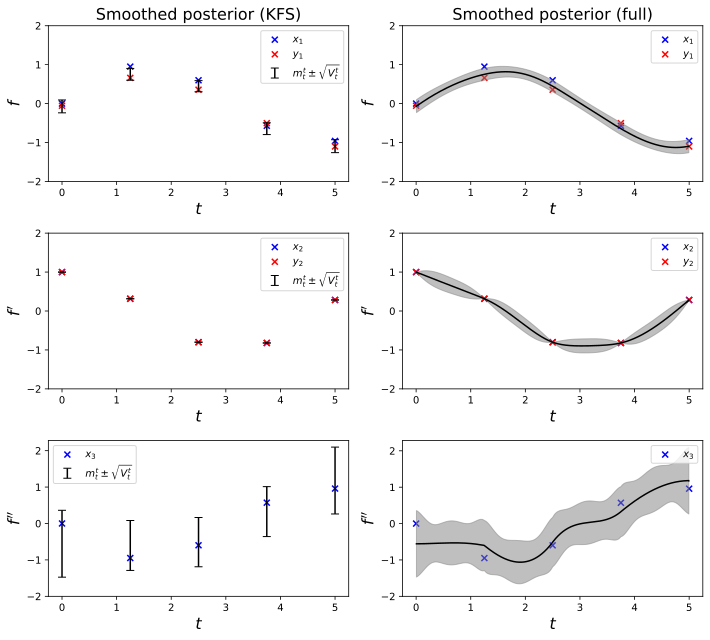

In [9]:
plt.figure(figsize=(10, 9))

for i in range(3):
    
    plt.subplot(3, 2, 2 * i + 1)
    
    plt.scatter(t, xs[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, ys[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (KFS)', fontsize=16)
    
    plt.errorbar(x=t,
                 y=ms[:, i],
                 yerr=2 * Vs[:, i, i] ** 0.5,
                 color='black',
                 zorder=2,
                 fmt="none",
                 label=r"$m_t^t \pm \sqrt{V_t^t}$",
                 capsize=4)
    
    plt.yticks(np.linspace(-2, 2, 5))
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()
    
    if i == 0:
        plt.ylabel(r'$f$', fontsize=16)
    if i == 1:
        plt.ylabel(r"$f'$", fontsize=16)
    if i == 2:
        plt.ylabel(r"$f''$", fontsize=16)

    plt.subplot(3, 2, 2 * i + 2)
    
    t_, m_, v_ = line_post_pred(dt, ms, Vs, CV)
    plt.plot(t_, m_[:, i], color='k')
    plt.scatter(t, xs[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(t, ys[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior (full)', fontsize=16)

    plt.fill_between(t_,
                     m_[:, i] - 2 * v_[:, i] ** 0.5,
                     m_[:, i] + 2 * v_[:, i] ** 0.5,
                     color='gray', alpha=0.5)
    plt.yticks(np.linspace(-2, 2, 5))
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()
    
    if i == 0:
        plt.ylabel(r'$f$', fontsize=16)
    if i == 1:
        plt.ylabel(r"$f'$", fontsize=16)
    if i == 2:
        plt.ylabel(r"$f''$", fontsize=16)

plt.tight_layout()
plt.savefig('figures/sine-posterior.svg')
plt.savefig('figures/sin-posterior.png')
plt.show()